In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp "/content/drive/MyDrive/UTKFace.tar.gz" .

In [ ]:
!tar xvzf UTKFace.tar.gz &> /dev/null

In [ ]:
from tensorflow.keras import *
from tensorflow.keras.utils import *
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import tensorboard
import os

In [ ]:
dot = '.'
underline = '_'
White =  "White"
Black  = "Black" 
Asian  = "Asian" 
Indian = "Indian" 
Others = "Others"

image = 'image'
Race  = 'Race'

# PHASE 1
# Reading and Preprocessing
Here are the steps we will follow in this section:
- Reading the train and test datasets
- Convert images to grayscale
- Change the size of the images to 100x100
- Print the number of read data points and the number of the categories 
- Setting the batch size to 32 (for the following sections to use)

# Data Visualization #
In order to have an intuitive understanding of our datasets, we will do the following:
<ol>
<p> 1.Display an image of every class of patients
<p> 2.Draw a histogram of the number of patients in each class
</ol>
For the tasks above, we loop through the given dataset, count the number of data points in each category and display the images of every new category (three categories\classes in total as mentioned above).

In [ ]:
img_path = list()
Races = list()

path = "/content/UTKFace"


for img in os.listdir(path):
  temp = img.split(dot)

  if len(temp[0].split(underline)) != 4:
    continue
  img_path.append(os.path.join(path, img))
  age, gender, race, date = temp[0].split(underline)
  Races.append(int(race))



classLabels = {0:White, 1:Black, 2:Asian, 3:Indian, 4:Others}

Races = [str(utils.to_categorical(i, len(classLabels))) for i in Races]

df = pd.DataFrame({
    image : img_path,
    Race : Races
})

TARGET_NAMES = df.Race.unique().tolist()

In [ ]:
df

,image,Race
0,/content/UTKFace/54_0_0_20170104212621156.jpg....,[1. 0. 0. 0. 0.]
1,/content/UTKFace/35_1_2_20170116181314698.jpg....,[0. 0. 1. 0. 0.]
2,/content/UTKFace/70_0_3_20170119205403079.jpg....,[0. 0. 0. 1. 0.]
3,/content/UTKFace/27_0_1_20170117172452375.jpg....,[0. 1. 0. 0. 0.]
4,/content/UTKFace/8_1_0_20170109203552679.jpg.c...,[1. 0. 0. 0. 0.]
...,...,...
23700,/content/UTKFace/25_1_1_20170116001921217.jpg....,[0. 1. 0. 0. 0.]
23701,/content/UTKFace/18_0_0_20170110223927225.jpg....,[1. 0. 0. 0. 0.]
23702,/content/UTKFace/53_0_0_20170104212413221.jpg....,[1. 0. 0. 0. 0.]
23703,/content/UTKFace/24_1_2_20170116174434040.jpg....,[0. 0. 1. 0. 0.]


In [ ]:
print("The number of read data is : " ,len(df))

The number of read data is :  23705


In [ ]:
df[Race].value_counts()

[1. 0. 0. 0. 0.]    10078
[0. 1. 0. 0. 0.]     4526
[0. 0. 0. 1. 0.]     3975
[0. 0. 1. 0. 0.]     3434
[0. 0. 0. 0. 1.]     1692
Name: Race, dtype: int64

In [ ]:
print("The number of Classes is : " ,len(df[Race].value_counts()))

The number of Classes is :  5


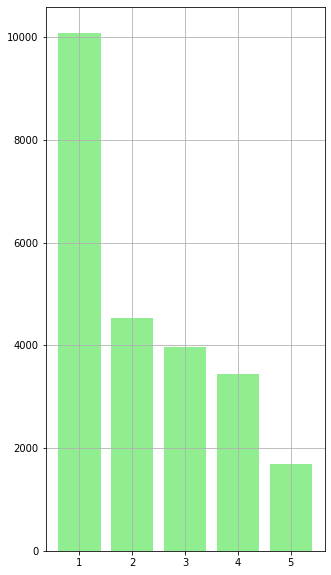

In [ ]:
ClassSize = pd.Series.tolist(df[Race].value_counts())

types = [x for x in range(1, 6)]
    
fig = plt.figure(figsize = (5, 10)) 
plt.bar(types, ClassSize, color ='lightgreen') 
plt.xticks(np.arange(1, 6, 1))
plt.grid(True)
plt.show()

In [ ]:
dataGenerator = preprocessing.image.ImageDataGenerator(
    rescale = 1/255.0,
    validation_split = 0.3
)

In [ ]:
TrainData = dataGenerator.flow_from_dataframe(
    dataframe = df,
    x_col = image,
    y_col = Race,
    target_size = (100, 100),
    color_mode = "grayscale",
    batch_size = 32,
    class_mode = 'categorical',
    subset = "training",
    shuffle = True
)

Found 16594 validated image filenames belonging to 5 classes.


In [ ]:
TestData = dataGenerator.flow_from_dataframe(
    dataframe = df,
    x_col = image,
    y_col = Race,
    target_size = (100, 100),
    color_mode = "grayscale",
    batch_size = 32,
    class_mode = 'categorical',
    subset = "validation",
    shuffle = True
)

Found 7111 validated image filenames belonging to 5 classes.


In [ ]:
TrainData.class_indices

{'[0. 0. 0. 0. 1.]': 0,
 '[0. 0. 0. 1. 0.]': 1,
 '[0. 0. 1. 0. 0.]': 2,
 '[0. 1. 0. 0. 0.]': 3,
 '[1. 0. 0. 0. 0.]': 4}

In [ ]:
TrainData.image_shape

(100, 100, 1)

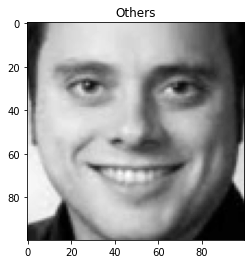

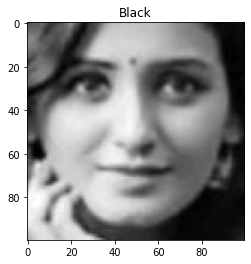

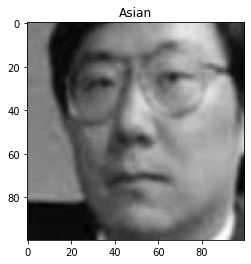

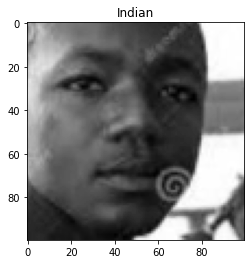

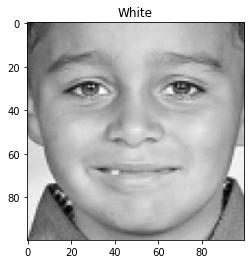

In [ ]:
images, labels = TrainData.next()
visited_labels = np.array(9)
for image, label in zip(images, labels):
  if ((visited_labels).size) >= 7:
    break
  type_index = backend.argmax(label).numpy()
  if type_index not in visited_labels:
    visited_labels = np.append(visited_labels, type_index)
    plt.title(classLabels[type_index])
    plt.imshow(image.reshape(100, 100), cmap="gray")
    plt.show()


# PHASE 2
# Traing the Model on the Test Dataset #
To train the model we need to have the labels of the test dataset. Since the labels are one-hot vectors, we will first change them to their true labels (the index of 1 in their corresponding vector).<br>
After converting the labels to integers, we can train the model, using the architechture we defined and trained above.

## Training Using ReLu Activation Function ##
As we can seen below, after 10 epochs the relu activation function results in almost perfect accuracy in the training set. The non-linearity of relu and the few number of layers, makes it efficient in our network. However, relu can not be used in networks with many layers due to the problem of vanishing gradients.<br>
<b>Advantages:</b><br>
- It is computationally effective as it involves simpler mathematical operations than sigmoid and tanh.
- Although it looks like a linear function, it adds non-linearity to the network, making it able to learn complex patterns.
- It doesn't suffer from the vanishing gradient problem.
- It is unbounded at the positive side. Hence removing the problem of gradient saturation.
- It provides sparsity to the network, which as a result lessens the space and time complexity. Sparse networks are always faster than dense networks as there are lesser things to compute in a sparse network. Sparsity results in concise models that often have better predictive power and less overfitting/noise.


<b>Disadvantages:</b><br>
- It suffers from the dying ReLU problem. ReLU is always going to discard the negative values i.e. the deactivations by making it 0. But because of this, the gradient of these units will also become 0 and by now we all know that 0 gradient means no weight updation during backpropagation. Simply speaking, the neurons which will go to this state will stop responding to the deviation of input or the error. This, as a result, hampers the ability of the model to fit the data properly.
-  It is non-differentiable at 0.

<b>Uses</b><br>

ReLU should be used in the hidden layers. As it is computationally less expensive than sigmoid and tanh, therefore it is <b>usually</b> a better choice than them. It is also to be noted that ReLU is faster than both tanh and sigmoid. Also in hidden layers, at a time only a few neurons are activated, making it efficient and easy for computation.


In [ ]:
def DrawPlots(history):
  LossPerEpoch = history.history['loss']
  AccuPerEpoch = history.history['accuracy']
  fig = plt.figure(figsize = (8, 2))

  plt.plot(LossPerEpoch, color = 'red')
  plt.xticks(np.arange(0, EPOCH, 1))
  plt.title("Loss")
  plt.grid(True)
  plt.show()

  fig = plt.figure(figsize = (8, 2))
  plt.plot(AccuPerEpoch, color = 'green')
  plt.xticks(np.arange(0, EPOCH, 1))
  plt.title("Accuracy")
  plt.grid(True)
  plt.show()
  
def ClassificationReport(model, TestData,TARGET_NAMES):
  predictions = model.predict_generator(TestData)
  yPred = np.rint(predictions)
  yPrednp = np.argmax(yPred, axis=1)

  yTrueList = TestData.classes
  yTruenp = np.array(yTrueList)
  print("\n\n\nClassification Report of this model is :\n")
  print(classification_report(yTruenp, yPrednp, target_names=TARGET_NAMES))

In [ ]:
LEARNING_RATE = 0.01
LOSS = "categorical_crossentropy"
METRICS = "accuracy"
EPOCH = 10

input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(1024, activation = "relu")(output)
output = layers.Dense(512,  activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE), loss = LOSS, metrics=[METRICS])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              10241024  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 10,768,389
Trainable params: 10,768,389
Non-trainable params: 0
_________________________________________________________________


 The number of parameters in each layer is the number of edges that need a weight. 
 
The number of nodes is neurons of the previous layer + 1 (for bias) multiply by the current layer

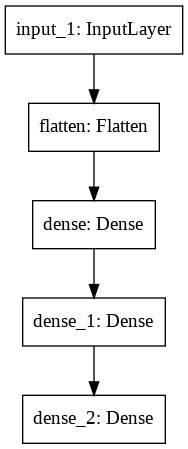

In [ ]:
utils.plot_model(model)

In [ ]:
history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

Epoch 1/10
519/519 [==============================] - 28s 52ms/step - loss: 1.2822 - accuracy: 0.4993 - val_loss: 1.1689 - val_accuracy: 0.5964
Epoch 2/10
519/519 [==============================] - 27s 51ms/step - loss: 1.1150 - accuracy: 0.5805 - val_loss: 1.0221 - val_accuracy: 0.6294
Epoch 3/10
519/519 [==============================] - 27s 51ms/step - loss: 1.0345 - accuracy: 0.6171 - val_loss: 0.9692 - val_accuracy: 0.6429
Epoch 4/10
519/519 [==============================] - 27s 51ms/step - loss: 0.9755 - accuracy: 0.6416 - val_loss: 0.9659 - val_accuracy: 0.6560
Epoch 5/10
519/519 [==============================] - 26s 51ms/step - loss: 0.9443 - accuracy: 0.6548 - val_loss: 0.8996 - val_accuracy: 0.6917
Epoch 6/10
519/519 [==============================] - 26s 51ms/step - loss: 0.9122 - accuracy: 0.6716 - val_loss: 0.9053 - val_accuracy: 0.6749
Epoch 7/10
519/519 [==============================] - 27s 51ms/step - loss: 0.8757 - accuracy: 0.6828 - val_loss: 1.1362 - val_accuracy:

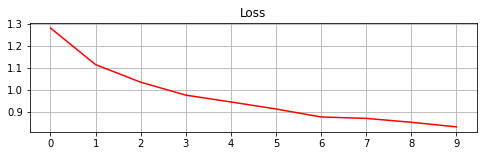

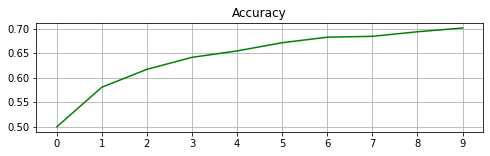

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.07      0.17      0.10       561
[0. 0. 1. 0. 0.]       0.17      0.05      0.08      1166
[0. 0. 0. 1. 0.]       0.18      0.15      0.16      1010
[0. 1. 0. 0. 0.]       0.18      0.19      0.19      1331
[0. 0. 0. 0. 1.]       0.43      0.46      0.45      3043

        accuracy                           0.28      7111
       macro avg       0.21      0.20      0.19      7111
    weighted avg       0.28      0.28      0.27      7111



In [ ]:
DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

# PHASE 3

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              10241024  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 2565      
Total params: 10,768,389
Trainable params: 10,768,389
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
519/519 [==============================] - 27s 52ms/step - loss: 1.2825 - accuracy: 0.4952 - val_loss:

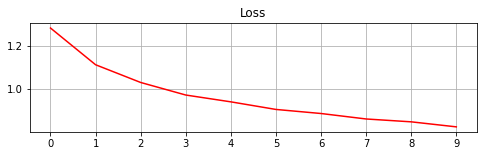

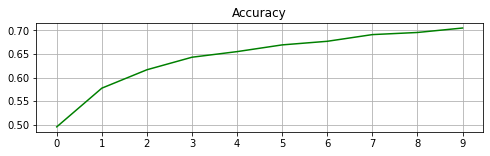

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.07      0.13      0.09       561
[0. 0. 1. 0. 0.]       0.15      0.08      0.10      1166
[0. 0. 0. 1. 0.]       0.13      0.06      0.09      1010
[0. 1. 0. 0. 0.]       0.20      0.14      0.17      1331
[0. 0. 0. 0. 1.]       0.42      0.55      0.48      3043

        accuracy                           0.29      7111
       macro avg       0.19      0.19      0.18      7111
    weighted avg       0.27      0.29      0.27      7111



In [ ]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(1024, activation = "relu")(output)
output = layers.Dense(512,  activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_120 (Dense)            (None, 1024)              10241024  
_________________________________________________________________
dense_121 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_122 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_123 (Dense)            (None, 5)                 1285      
Total params: 10,898,437
Trainable params: 10,898,437
Non-trainable params: 0
______________________________________________

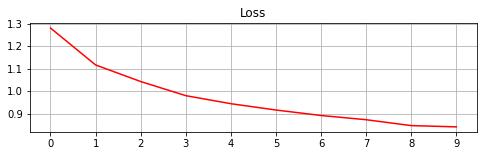

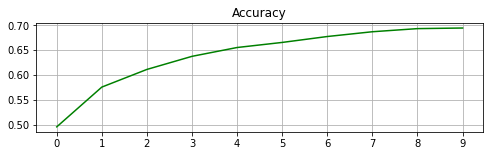

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.08      0.25      0.12       561
[0. 0. 1. 0. 0.]       0.16      0.09      0.11      1166
[0. 0. 0. 1. 0.]       0.14      0.11      0.13      1010
[0. 1. 0. 0. 0.]       0.21      0.19      0.20      1331
[0. 0. 0. 0. 1.]       0.44      0.40      0.42      3043

        accuracy                           0.26      7111
       macro avg       0.21      0.21      0.20      7111
    weighted avg       0.28      0.26      0.26      7111



In [54]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(1024, activation = "relu")(output)
output = layers.Dense(512, activation = "relu")(output)
output = layers.Dense(256, activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 645       
Total params: 10,832,133
Trainable params: 10,832,133
Non-trainable params: 0
_______________________________________________

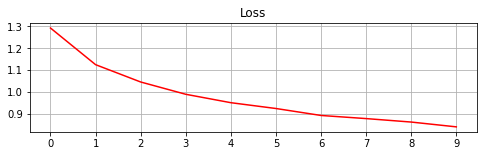

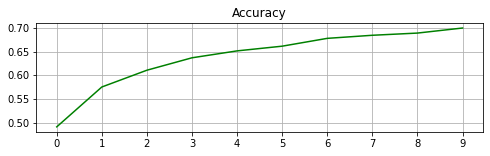

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.08      0.24      0.12       561
[0. 0. 1. 0. 0.]       0.17      0.19      0.18      1166
[0. 0. 0. 1. 0.]       0.15      0.11      0.13      1010
[0. 1. 0. 0. 0.]       0.18      0.14      0.16      1331
[0. 0. 0. 0. 1.]       0.43      0.34      0.38      3043

        accuracy                           0.24      7111
       macro avg       0.20      0.20      0.19      7111
    weighted avg       0.27      0.24      0.25      7111



In [ ]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(1024, activation = "relu")(output)
output = layers.Dense(512, activation = "relu")(output)
output = layers.Dense(128, activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_115 (Dense)            (None, 1024)              10241024  
_________________________________________________________________
dense_116 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_117 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_118 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_119 (Dense)            (None, 5)                 645

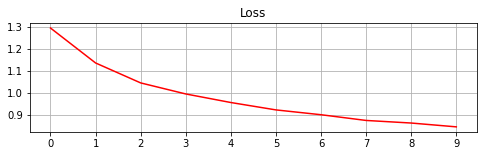

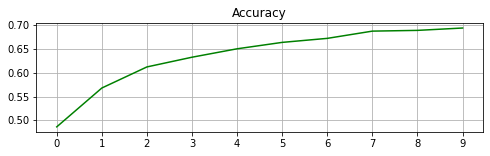

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.08      0.25      0.12       561
[0. 0. 1. 0. 0.]       0.17      0.05      0.07      1166
[0. 0. 0. 1. 0.]       0.15      0.17      0.16      1010
[0. 1. 0. 0. 0.]       0.18      0.16      0.17      1331
[0. 0. 0. 0. 1.]       0.42      0.37      0.39      3043

        accuracy                           0.24      7111
       macro avg       0.20      0.20      0.18      7111
    weighted avg       0.27      0.24      0.24      7111



In [53]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(1024, activation = "relu")(output)
output = layers.Dense(512, activation = "relu")(output)
output = layers.Dense(256, activation = "relu")(output)
output = layers.Dense(128, activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dense_20 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 325       
Total params: 10,380,805
Trainable params: 10,380,805
Non-trainable params: 0
_______________________________________________

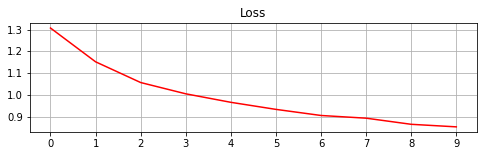

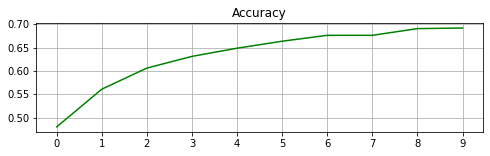

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.08      0.24      0.12       561
[0. 0. 1. 0. 0.]       0.15      0.05      0.08      1166
[0. 0. 0. 1. 0.]       0.14      0.07      0.09      1010
[0. 1. 0. 0. 0.]       0.18      0.14      0.16      1331
[0. 0. 0. 0. 1.]       0.43      0.48      0.45      3043

        accuracy                           0.27      7111
       macro avg       0.19      0.20      0.18      7111
    weighted avg       0.27      0.27      0.26      7111



In [ ]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(1024, activation = "relu")(output)
output = layers.Dense(128, activation = "relu")(output)
output = layers.Dense(64, activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               2560256   
_________________________________________________________________
dense_24 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_25 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 325       
Total params: 2,601,733
Trainable params: 2,601,733
Non-trainable params: 0
_________________________________________________

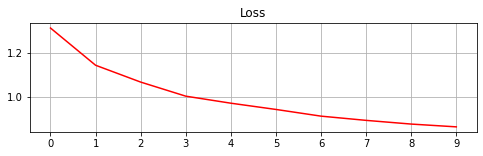

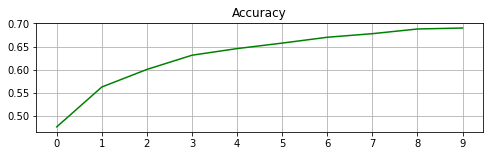

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.09      0.20      0.12       561
[0. 0. 1. 0. 0.]       0.15      0.08      0.11      1166
[0. 0. 0. 1. 0.]       0.13      0.08      0.10      1010
[0. 1. 0. 0. 0.]       0.20      0.16      0.17      1331
[0. 0. 0. 0. 1.]       0.43      0.49      0.46      3043

        accuracy                           0.28      7111
       macro avg       0.20      0.20      0.19      7111
    weighted avg       0.27      0.28      0.27      7111



In [ ]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(256, activation = "relu")(output)
output = layers.Dense(128, activation = "relu")(output)
output = layers.Dense(64, activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dense_28 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_29 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_30 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_31 (Dense)             (None, 64)                8256

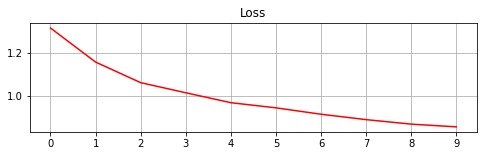

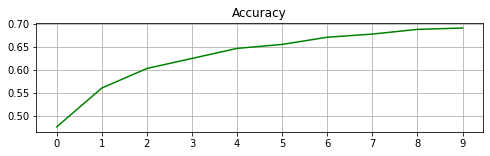

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.08      0.25      0.12       561
[0. 0. 1. 0. 0.]       0.17      0.08      0.11      1166
[0. 0. 0. 1. 0.]       0.14      0.13      0.13      1010
[0. 1. 0. 0. 0.]       0.19      0.12      0.15      1331
[0. 0. 0. 0. 1.]       0.43      0.44      0.43      3043

        accuracy                           0.26      7111
       macro avg       0.20      0.20      0.19      7111
    weighted avg       0.27      0.26      0.26      7111



In [ ]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(1024, activation = "relu")(output)
output = layers.Dense(512, activation = "relu")(output)
output = layers.Dense(256, activation = "relu")(output)
output = layers.Dense(128, activation = "relu")(output)
output = layers.Dense(64, activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 100)               1000100   
_________________________________________________________________
dense_34 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_35 (Dense)             (None, 5)                 505       
Total params: 1,010,705
Trainable params: 1,010,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
519/519 [==============================] - 26s 50ms/step - loss: 1.3227 - accuracy: 0.4739 - val_loss: 1

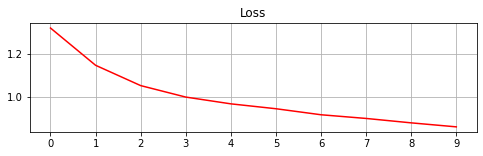

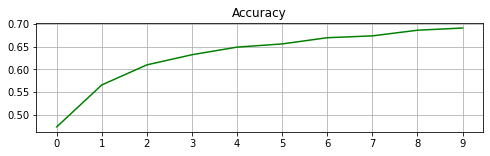

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.08      0.21      0.11       561
[0. 0. 1. 0. 0.]       0.17      0.13      0.14      1166
[0. 0. 0. 1. 0.]       0.16      0.13      0.14      1010
[0. 1. 0. 0. 0.]       0.18      0.15      0.16      1331
[0. 0. 0. 0. 1.]       0.44      0.41      0.42      3043

        accuracy                           0.26      7111
       macro avg       0.21      0.20      0.20      7111
    weighted avg       0.28      0.26      0.26      7111



In [ ]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(100, activation = "relu")(output)
output = layers.Dense(100,  activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 300)               3000300   
_________________________________________________________________
dense_37 (Dense)             (None, 600)               180600    
_________________________________________________________________
dense_38 (Dense)             (None, 5)                 3005      
Total params: 3,183,905
Trainable params: 3,183,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
519/519 [==============================] - 27s 50ms/step - loss: 1.2887 - accuracy: 0.4878 - val_loss: 1

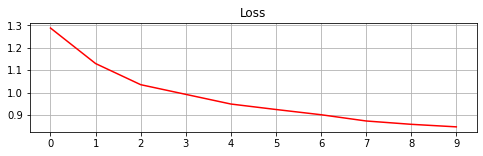

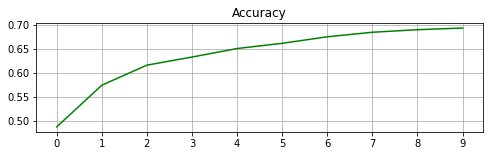

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.07      0.22      0.11       561
[0. 0. 1. 0. 0.]       0.16      0.12      0.14      1166
[0. 0. 0. 1. 0.]       0.14      0.11      0.12      1010
[0. 1. 0. 0. 0.]       0.20      0.18      0.19      1331
[0. 0. 0. 0. 1.]       0.43      0.36      0.40      3043

        accuracy                           0.24      7111
       macro avg       0.20      0.20      0.19      7111
    weighted avg       0.28      0.24      0.25      7111



In [ ]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(300, activation = "relu")(output)
output = layers.Dense(600,  activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 600)               6000600   
_________________________________________________________________
dense_40 (Dense)             (None, 300)               180300    
_________________________________________________________________
dense_41 (Dense)             (None, 5)                 1505      
Total params: 6,182,405
Trainable params: 6,182,405
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
519/519 [==============================] - 27s 51ms/step - loss: 1.2847 - accuracy: 0.4935 - val_loss: 

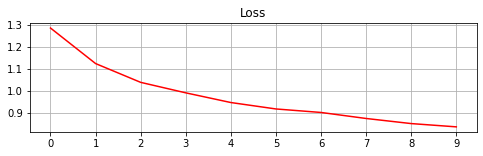

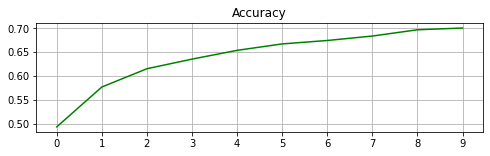

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.07      0.20      0.10       561
[0. 0. 1. 0. 0.]       0.16      0.07      0.10      1166
[0. 0. 0. 1. 0.]       0.15      0.19      0.17      1010
[0. 1. 0. 0. 0.]       0.19      0.18      0.19      1331
[0. 0. 0. 0. 1.]       0.43      0.36      0.39      3043

        accuracy                           0.24      7111
       macro avg       0.20      0.20      0.19      7111
    weighted avg       0.27      0.24      0.25      7111



In [ ]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(600, activation = "relu")(output)
output = layers.Dense(300,  activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_42 (Dense)             (None, 100)               1000100   
_________________________________________________________________
dense_43 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_44 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_45 (Dense)             (None, 5)                 505       
Total params: 1,020,805
Trainable params: 1,020,805
Non-trainable params: 0
________________________________________________

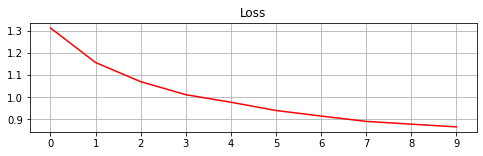

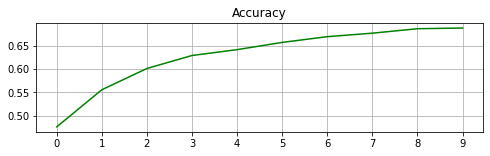

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.08      0.20      0.11       561
[0. 0. 1. 0. 0.]       0.16      0.10      0.12      1166
[0. 0. 0. 1. 0.]       0.13      0.11      0.12      1010
[0. 1. 0. 0. 0.]       0.18      0.08      0.12      1331
[0. 0. 0. 0. 1.]       0.43      0.50      0.46      3043

        accuracy                           0.28      7111
       macro avg       0.20      0.20      0.19      7111
    weighted avg       0.27      0.28      0.27      7111



In [ ]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(100, activation = "relu")(output)
output = layers.Dense(100,  activation = "relu")(output)
output = layers.Dense(100,  activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_46 (Dense)             (None, 300)               3000300   
_________________________________________________________________
dense_47 (Dense)             (None, 600)               180600    
_________________________________________________________________
dense_48 (Dense)             (None, 900)               540900    
_________________________________________________________________
dense_49 (Dense)             (None, 5)                 4505      
Total params: 3,726,305
Trainable params: 3,726,305
Non-trainable params: 0
________________________________________________

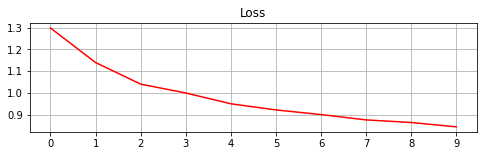

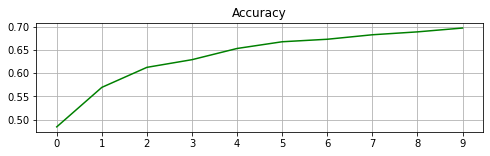

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.09      0.21      0.13       561
[0. 0. 1. 0. 0.]       0.16      0.03      0.06      1166
[0. 0. 0. 1. 0.]       0.15      0.12      0.13      1010
[0. 1. 0. 0. 0.]       0.17      0.16      0.16      1331
[0. 0. 0. 0. 1.]       0.43      0.51      0.47      3043

        accuracy                           0.29      7111
       macro avg       0.20      0.21      0.19      7111
    weighted avg       0.27      0.29      0.27      7111



In [ ]:
LEARNING_RATE = 0.01

input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(300, activation = "relu")(output)
output = layers.Dense(600,  activation = "relu")(output)
output = layers.Dense(900,  activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_50 (Dense)             (None, 512)               5120512   
_________________________________________________________________
dense_51 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_52 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_53 (Dense)             (None, 5)                 2565      
Total params: 6,173,189
Trainable params: 6,173,189
Non-trainable params: 0
________________________________________________

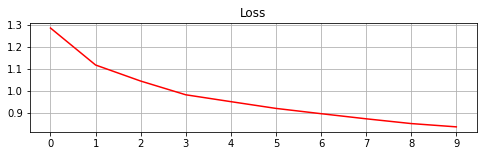

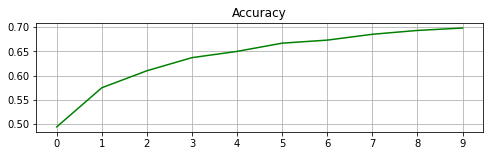

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.08      0.28      0.12       561
[0. 0. 1. 0. 0.]       0.16      0.13      0.14      1166
[0. 0. 0. 1. 0.]       0.13      0.07      0.09      1010
[0. 1. 0. 0. 0.]       0.18      0.21      0.19      1331
[0. 0. 0. 0. 1.]       0.42      0.26      0.32      3043

        accuracy                           0.21      7111
       macro avg       0.19      0.19      0.17      7111
    weighted avg       0.26      0.21      0.22      7111



In [ ]:
LEARNING_RATE = 0.01

input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(512, activation = "relu")(output)
output = layers.Dense(1024,  activation = "relu")(output)
output = layers.Dense(512,  activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_54 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dense_55 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_56 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_57 (Dense)             (None, 5)                 5125      
Total params: 11,296,261
Trainable params: 11,296,261
Non-trainable params: 0
______________________________________________

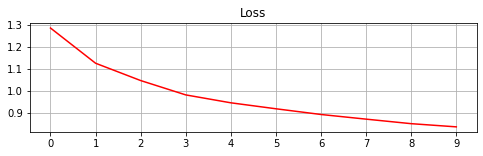

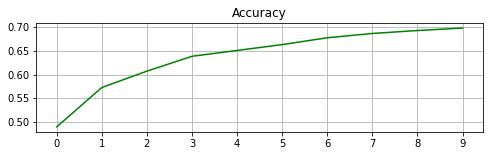

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.08      0.33      0.13       561
[0. 0. 1. 0. 0.]       0.18      0.17      0.18      1166
[0. 0. 0. 1. 0.]       0.15      0.15      0.15      1010
[0. 1. 0. 0. 0.]       0.18      0.18      0.18      1331
[0. 0. 0. 0. 1.]       0.44      0.20      0.27      3043

        accuracy                           0.19      7111
       macro avg       0.21      0.21      0.18      7111
    weighted avg       0.28      0.19      0.21      7111



In [ ]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(1024, activation = "relu")(output)
output = layers.Dense(512,  activation = "relu")(output)
output = layers.Dense(1024, activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_58 (Dense)             (None, 512)               5120512   
_________________________________________________________________
dense_59 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_60 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_61 (Dense)             (None, 5)                 2565      
Total params: 5,648,389
Trainable params: 5,648,389
Non-trainable params: 0
________________________________________________

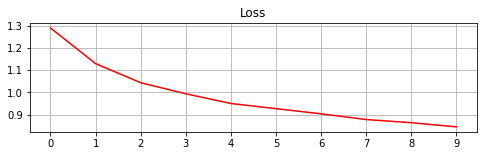

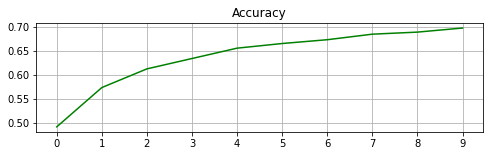

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.07      0.18      0.10       561
[0. 0. 1. 0. 0.]       0.19      0.09      0.12      1166
[0. 0. 0. 1. 0.]       0.14      0.21      0.17      1010
[0. 1. 0. 0. 0.]       0.21      0.12      0.16      1331
[0. 0. 0. 0. 1.]       0.44      0.40      0.41      3043

        accuracy                           0.25      7111
       macro avg       0.21      0.20      0.19      7111
    weighted avg       0.28      0.25      0.26      7111



In [ ]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(512, activation = "relu")(output)
output = layers.Dense(512,  activation = "relu")(output)
output = layers.Dense(512, activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_62 (Dense)             (None, 1000)              10001000  
_________________________________________________________________
dense_63 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_64 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_65 (Dense)             (None, 5)                 5005      
Total params: 12,008,005
Trainable params: 12,008,005
Non-trainable params: 0
______________________________________________

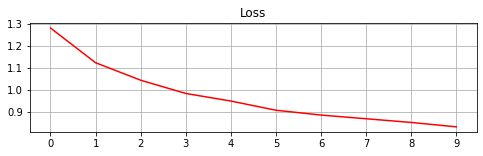

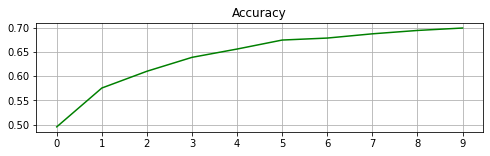

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.08      0.16      0.11       561
[0. 0. 1. 0. 0.]       0.16      0.08      0.11      1166
[0. 0. 0. 1. 0.]       0.15      0.13      0.14      1010
[0. 1. 0. 0. 0.]       0.19      0.12      0.15      1331
[0. 0. 0. 0. 1.]       0.43      0.51      0.47      3043

        accuracy                           0.29      7111
       macro avg       0.20      0.20      0.19      7111
    weighted avg       0.27      0.29      0.27      7111



In [ ]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(1000, activation = "relu")(output)
output = layers.Dense(1000,  activation = "relu")(output)
output = layers.Dense(1000, activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_66 (Dense)             (None, 200)               2000200   
_________________________________________________________________
dense_67 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_68 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_69 (Dense)             (None, 5)                 1005      
Total params: 2,081,605
Trainable params: 2,081,605
Non-trainable params: 0
________________________________________________

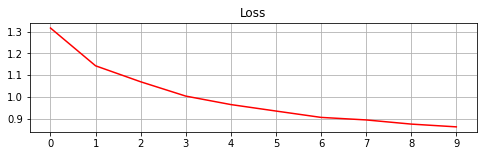

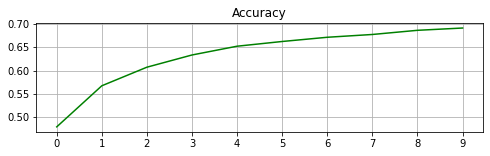

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.09      0.26      0.13       561
[0. 0. 1. 0. 0.]       0.17      0.10      0.13      1166
[0. 0. 0. 1. 0.]       0.15      0.15      0.15      1010
[0. 1. 0. 0. 0.]       0.20      0.11      0.14      1331
[0. 0. 0. 0. 1.]       0.43      0.44      0.44      3043

        accuracy                           0.27      7111
       macro avg       0.21      0.21      0.20      7111
    weighted avg       0.28      0.27      0.27      7111



In [ ]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(200, activation = "relu")(output)
output = layers.Dense(200,  activation = "relu")(output)
output = layers.Dense(200, activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_70 (Dense)             (None, 512)               5120512   
_________________________________________________________________
dense_71 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_72 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_73 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_74 (Dense)             (None, 5)                 512

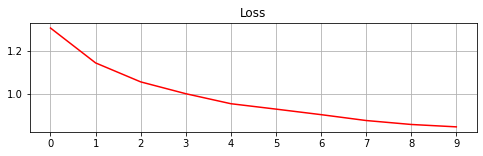

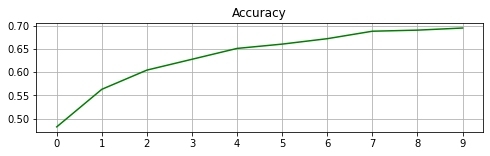

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.08      0.20      0.11       561
[0. 0. 1. 0. 0.]       0.16      0.11      0.13      1166
[0. 0. 0. 1. 0.]       0.14      0.12      0.13      1010
[0. 1. 0. 0. 0.]       0.19      0.15      0.17      1331
[0. 0. 0. 0. 1.]       0.43      0.42      0.43      3043

        accuracy                           0.26      7111
       macro avg       0.20      0.20      0.19      7111
    weighted avg       0.27      0.26      0.26      7111



In [ ]:
LEARNING_RATE = 0.01

input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(512, activation = "relu")(output)
output = layers.Dense(1024,  activation = "relu")(output)
output = layers.Dense(512,  activation = "relu")(output)
output = layers.Dense(1024,  activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

# PART 1
# MOMENTUM

Optimizer helps us to minimize an error function(loss function)or to maximize the efficiency of production .In this section we will apply two other optimizers: momentum and Adam

## Momentum : What is it and why is it useful? ##
Momentum is not soley an optimizer, it is an improvement on Stochastic Gradient Descent. When looking at noisy time series data such as your training/validation error graphs in tensorboard, you may often notice that the raw values are often quite noisy. Quite often, you are able to see a trend in the graph. These trends often become more obvious when you add some smoothing to the raw graph values.<br>

Exponential Smoothing is one of the simplest ways to add smoothing to your data.<br>
Exponential Smoothing Formula:
$$ s_0 = x_0 s_t = ax_t + (1-\alpha)s_{t-1}, t>0, 0<= \alpha <=1$$
In the above equation, momentum specifies the amount of smoothing we want. A typical value for momentum is .9. From this equation, we can see that the value at time step t takes into account previous values from time steps (t — 1) and before. The weighting of previous time steps drops off exponentially so the most recent time step has the greatest impact.The momentum optimizer uses this same equation when optimizing a loss function. In this case, the Exponential Smoothing is called Momentum and it allows the optimizer to maintain the velocity and trajectory from previous time steps to affect the present.

## Is Momentum always a good optimizer? ##
 Unfortunately, while improvements to the momentum algorithm do exist, they all run into a certain, critical, almost inescapable lower bound. That means, we can not always apply momentum and get better results.




 ## Implementing Momentum Optimizer on Our Model ##
 From the models below, we can see that the method of <b> early stopping</b> applies for momentum too. When it is increased from 0.5 to 0.9 the model is improved but for momentum 0.99 the model has deteriorated.<br>
 Momentum = 0.5

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_75 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dense_76 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_77 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_78 (Dense)             (None, 5)                 1285      
Total params: 10,898,437
Trainable params: 10,898,437
Non-trainable params: 0
______________________________________________

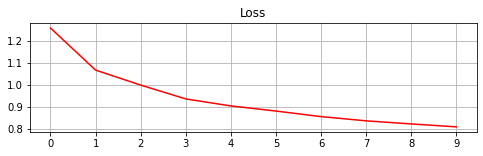

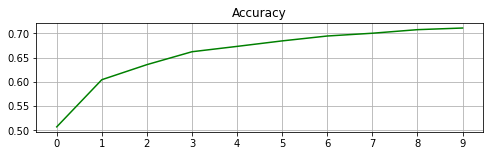

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.08      0.18      0.11       561
[0. 0. 1. 0. 0.]       0.19      0.06      0.09      1166
[0. 0. 0. 1. 0.]       0.13      0.15      0.14      1010
[0. 1. 0. 0. 0.]       0.19      0.18      0.18      1331
[0. 0. 0. 0. 1.]       0.43      0.44      0.44      3043

        accuracy                           0.27      7111
       macro avg       0.20      0.20      0.19      7111
    weighted avg       0.28      0.27      0.26      7111



In [ ]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(1024, activation = "relu")(output)
output = layers.Dense(512,  activation = "relu")(output)
output = layers.Dense(256,  activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.5), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_79 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dense_80 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_81 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_82 (Dense)             (None, 5)                 1285      
Total params: 10,898,437
Trainable params: 10,898,437
Non-trainable params: 0
______________________________________________

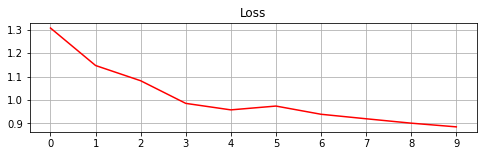

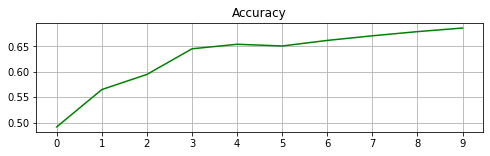

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.08      0.28      0.13       561
[0. 0. 1. 0. 0.]       0.17      0.16      0.16      1166
[0. 0. 0. 1. 0.]       0.13      0.03      0.05      1010
[0. 1. 0. 0. 0.]       0.19      0.16      0.17      1331
[0. 0. 0. 0. 1.]       0.42      0.38      0.40      3043

        accuracy                           0.25      7111
       macro avg       0.20      0.20      0.18      7111
    weighted avg       0.27      0.25      0.25      7111



In [ ]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(1024, activation = "relu")(output)
output = layers.Dense(512,  activation = "relu")(output)
output = layers.Dense(256,  activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_83 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dense_84 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_85 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_86 (Dense)             (None, 5)                 1285      
Total params: 10,898,437
Trainable params: 10,898,437
Non-trainable params: 0
______________________________________________

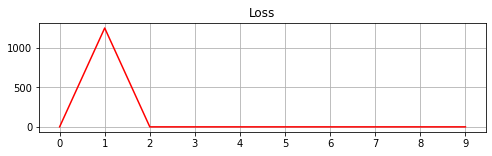

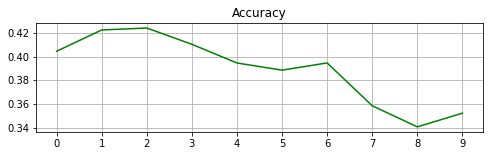

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.00      0.00      0.00       561
[0. 0. 1. 0. 0.]       0.00      0.00      0.00      1166
[0. 0. 0. 1. 0.]       0.00      0.00      0.00      1010
[0. 1. 0. 0. 0.]       0.00      0.00      0.00      1331
[0. 0. 0. 0. 1.]       0.43      1.00      0.60      3043

        accuracy                           0.43      7111
       macro avg       0.09      0.20      0.12      7111
    weighted avg       0.18      0.43      0.26      7111



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(1024, activation = "relu")(output)
output = layers.Dense(512,  activation = "relu")(output)
output = layers.Dense(256,  activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.999), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

# ADAM

Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.

Adam was presented by Diederik Kingma from OpenAI and Jimmy Ba from the University of Toronto in their 2015 ICLR paper (poster) titled “Adam: A Method for Stochastic Optimization“. I will quote liberally from their paper in this post, unless stated otherwise.

The algorithm is called Adam. It is not an acronym and is not written as “ADAM”.

    … the name Adam is derived from adaptive moment estimation.

When introducing the algorithm, the authors list the attractive benefits of using Adam on non-convex optimization problems, as follows:

-    Straightforward to implement.
-    Computationally efficient.
-    Little memory requirements.
-    Invariant to diagonal rescale of the gradients.
-    Well suited for problems that are large in terms of data and/or parameters.
-    Appropriate for non-stationary objectives.
-    Appropriate for problems with very noisy/or sparse gradients.
-    Hyper-parameters have intuitive interpretation and typically require little tuning.

### How Does Adam Work? ###

Adam is different to classical stochastic gradient descent.

Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.

A learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds.
<br>The method computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients.

The authors describe Adam as combining the advantages of two other extensions of stochastic gradient descent. Specifically:

Instead of adapting the parameter learning rates based on the average first moment (the mean), Adam also makes use of the average of the second moments of the gradients (the uncentered variance).

Specifically, the algorithm calculates an exponential moving average of the gradient and the squared gradient, and the parameters beta1 and beta2 control the decay rates of these moving averages.

The initial value of the moving averages and beta1 and beta2 values close to 1.0 (recommended) result in a bias of moment estimates towards zero. This bias is overcome by first calculating the biased estimates before then calculating bias-corrected estimates.

<b>Adam is Effective</b><br>

Adam is a popular algorithm in the field of deep learning because it achieves good results fast.<br>
Empirical results demonstrate that Adam works well in practice and compares favorably to other stochastic optimization methods.

<b>Adam VS SGD</b><br>
To better understand the paper’s implications, it is necessary to first look at the pros and cons of popular optimization algorithms Adam and SGD.

Gradient descent is the most common method used to optimize deep learning networks. First proposed in the 1950s, the technique can update each parameter of a model, observe how a change would affect the objective function, choose a direction that would lower the error rate, and continue iterating until the objective function converges to the minimum.

SGD is a variant of gradient descent. Instead of performing computations on the whole dataset — which is redundant and inefficient — SGD only computes on a small subset or random selection of data examples. SGD produces the same performance as regular gradient descent when the learning rate is low.

Essentially Adam is an algorithm for gradient-based optimization of stochastic objective functions. It combines the advantages of two SGD extensions — Root Mean Square Propagation (RMSProp) and Adaptive Gradient Algorithm (AdaGrad) — and computes individual adaptive learning rates for different parameters.

Despite the widespread popularity of Adam, recent research papers have noted that it can fail to converge to an optimal solution under specific settings. The paper Improving Generalization Performance by Switching from Adam to SGD demonstrates that adaptive optimization techniques such as Adam generalize poorly compared to SGD. This has prompted some researchers to explore new techniques that may improve on Adam

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_87 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dense_88 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_89 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_90 (Dense)             (None, 5)                 1285      
Total params: 10,898,437
Trainable params: 10,898,437
Non-trainable params: 0
______________________________________________

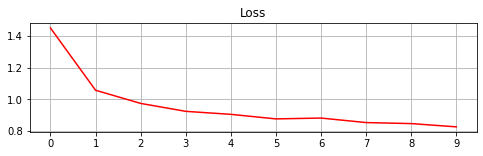

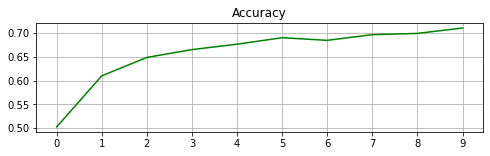

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.07      0.17      0.10       561
[0. 0. 1. 0. 0.]       0.16      0.08      0.11      1166
[0. 0. 0. 1. 0.]       0.15      0.14      0.14      1010
[0. 1. 0. 0. 0.]       0.18      0.19      0.18      1331
[0. 0. 0. 0. 1.]       0.43      0.41      0.42      3043

        accuracy                           0.26      7111
       macro avg       0.20      0.20      0.19      7111
    weighted avg       0.27      0.26      0.26      7111



In [ ]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(1024, activation = "relu")(output)
output = layers.Dense(512,  activation = "relu")(output)
output = layers.Dense(256,  activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

# PART 2
# EPOCH
## Why are epochs necesary? ##
Generally whenever we want to optimize we use gradient descent. Gradient descent has a parameter called learning rate. In one iteration alone we can not guarantee that the gradient descent algorithm would converge to a local minima with the specified learning rate. That is the reason why we iterate again for the gradient descent to converge better.
## Do all problems need multiple epochs? ##
If the optimization is straight forward in a problem, for example if we have a linear equation to optimize, we could reach the solution with even a single pass through the dataset. That is why multiple epochs are not necessary for all problems.
## Is a large number of EPOCHS always beneficial for the problem? ##
Not necessarily. The correct answer is the number of epochs is not that significant. more important is the validation and training error. As long as these two error keeps dropping, training should continue.<br>
For instance, if the validation error starts increasing that might be an indication of overfitting.

You should set the number of epochs as high as possible and terminate the training when validation error start increasing

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_91 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dense_92 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_93 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_94 (Dense)             (None, 5)                 1285      
Total params: 10,898,437
Trainable params: 10,898,437
Non-trainable params: 0
______________________________________________

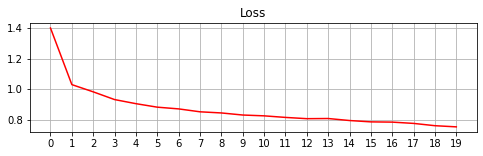

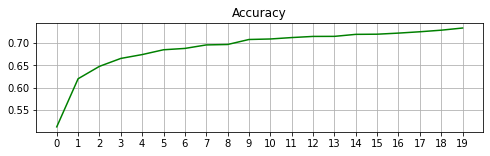

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.08      0.19      0.11       561
[0. 0. 1. 0. 0.]       0.15      0.10      0.12      1166
[0. 0. 0. 1. 0.]       0.14      0.15      0.14      1010
[0. 1. 0. 0. 0.]       0.19      0.16      0.17      1331
[0. 0. 0. 0. 1.]       0.43      0.38      0.40      3043

        accuracy                           0.24      7111
       macro avg       0.20      0.20      0.19      7111
    weighted avg       0.27      0.24      0.25      7111



In [ ]:
EPOCH = 20

input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(1024, activation = "relu")(output)
output = layers.Dense(512,  activation = "relu")(output)
output = layers.Dense(256,  activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_95 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dense_96 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_97 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_98 (Dense)             (None, 5)                 1285      
Total params: 10,898,437
Trainable params: 10,898,437
Non-trainable params: 0
______________________________________________

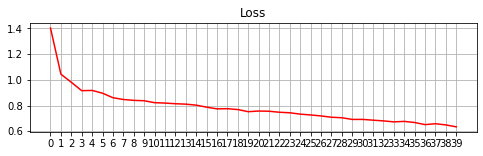

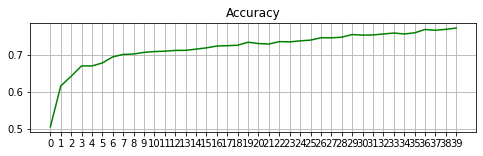

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.08      0.13      0.10       561
[0. 0. 1. 0. 0.]       0.15      0.13      0.14      1166
[0. 0. 0. 1. 0.]       0.15      0.14      0.15      1010
[0. 1. 0. 0. 0.]       0.18      0.20      0.19      1331
[0. 0. 0. 0. 1.]       0.42      0.38      0.40      3043

        accuracy                           0.25      7111
       macro avg       0.20      0.20      0.20      7111
    weighted avg       0.27      0.25      0.26      7111



In [ ]:
EPOCH = 40

input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(1024, activation = "relu")(output)
output = layers.Dense(512,  activation = "relu")(output)
output = layers.Dense(256,  activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

# PART 3
# LOSS FUNCTION
Here we want to replace categorical cross entropy with the MSE loss function. MSE is the sum of squared distances between our target variable and predicted values. As we can see below, categorical cross entropy, results in a better (more accurate model) for classification.


Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_99 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dense_100 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_101 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_102 (Dense)            (None, 5)                 1285      
Total params: 10,898,437
Trainable params: 10,898,437
Non-trainable params: 0
______________________________________________

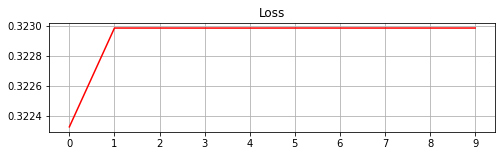

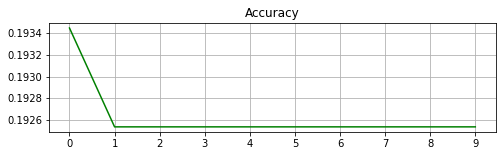

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.00      0.00      0.00       561
[0. 0. 1. 0. 0.]       0.00      0.00      0.00      1166
[0. 0. 0. 1. 0.]       0.00      0.00      0.00      1010
[0. 1. 0. 0. 0.]       0.19      1.00      0.32      1331
[0. 0. 0. 0. 1.]       0.00      0.00      0.00      3043

        accuracy                           0.19      7111
       macro avg       0.04      0.20      0.06      7111
    weighted avg       0.04      0.19      0.06      7111



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
EPOCH = 10
LOSS = 'mean_squared_error'

input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(1024, activation = "relu")(output)
output = layers.Dense(512,  activation = "relu")(output)
output = layers.Dense(256,  activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

# Why is MSE not suitable for classification? ###
Firstly, using MSE means that we assume that the underlying data has been generated from a normal distribution (a bell-shaped curve). In Bayesian terms this means we assume a Gaussian prior. While in reality, a dataset that can be classified into categories is not from a normal distribution but a Bernoulli distribution.<br>
If we use maximum likelihood estimation(MLE), assuming that the data is from a normal distribution(a wrong assumption, by the way), we get the MSE as a Cost function for optimizing our model.<br><br>
Secondly, the MSE function is non-convex for binary classification. In simple terms, if a binary classification model is trained with MSE Cost function, it is not guaranteed to minimize the Cost function. This is because MSE function expects real-valued inputs in range(-∞, ∞), while binary classification models output probabilities in range(0,1) through the sigmoid/logistic function.<br><br>
When the MSE function is passed a value that is unbounded a nice U-shaped (convex) curve is the result where there is a clear minimum point at the target value (y). On the other hand, when a bounded value from a Sigmoid function is passed to the MSE function the result is not convex; on one side the function is concave while on the other side the function convex and no clear minimum point. So, if by accident a binary classification neural network is initialized with weights which are large in magnitude such that it lands on the concave part of the MSE Cost function gradient descent will not work and consequently, weights may not update or improve very slowly.<br><br>
On a final note, MSE is a good choice for a Cost function when we are doing Linear Regression (i.e fitting a line through data for extrapolation). In the absence of any knowledge of how the data is distributed assuming normal/gaussian distribution is perfectly reasonable.

# PART 4
# REGULARIZATION

One of the major aspects of training your machine learning model is avoiding overfitting. The model will have a low accuracy if it is overfitting. This happens because your model is trying too hard to capture the noise in your training dataset. By noise we mean the data points that don’t really represent the true properties of your data, but random chance. Learning such data points, makes your model more flexible, at the risk of overfitting.<br>
A modern approach to reducing generalization error is to use a larger model that may be required to use regularization during training that keeps the weights of the model small. These techniques not only reduce overfitting, but they can also lead to faster optimization of the model and better overall performance.<br>
There are two ways to approach an overfit model:

-  Reduce overfitting by training the network on more examples.
-   Reduce overfitting by changing the complexity of the network.

Below is a list of five of the most common additional regularization methods.

- 1.Activity Regularization: Penalize the model during training base on the magnitude of the activations.
- 2.Weight Constraint: Constrain the magnitude of weights to be within a range or below a limit.
- 3.Dropout: Probabilistically remove inputs during training.
- 4.Noise: Add statistical noise to inputs during training.
- 5.Early Stopping: Monitor model performance on a validation set and stop training when performance degrades.



## L2 Regularization ##
We reimplemnt our model with the L2 Regularization in Keras with a value of 0.0001. L1 regularization adds the penalty term in cost function by adding the absolute value of weight(Wj) parameters, while L2 regularization adds the squared value of weights in the cost function. This improves the accuracy, as seen below.

Loss function with L1 regularization:
$$ Loss = Error(y,\hat y) + \lambda \sum_{i=1}^{N} |w_i|$$

Loss function with L2 regularization:
$$ Loss = Error(y,\hat y) + \lambda \sum_{i=1}^{N} w_i^{2}$$

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_103 (Dense)            (None, 1024)              10241024  
_________________________________________________________________
dense_104 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_105 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_106 (Dense)            (None, 5)                 1285      
Total params: 10,898,437
Trainable params: 10,898,437
Non-trainable params: 0
______________________________________________

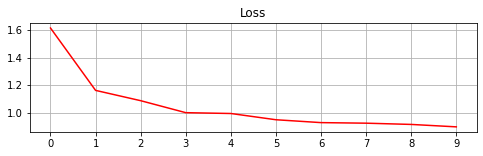

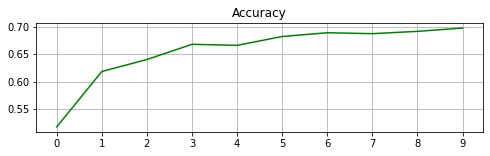

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.08      0.17      0.11       561
[0. 0. 1. 0. 0.]       0.17      0.03      0.04      1166
[0. 0. 0. 1. 0.]       0.13      0.18      0.15      1010
[0. 1. 0. 0. 0.]       0.20      0.20      0.20      1331
[0. 0. 0. 0. 1.]       0.43      0.43      0.43      3043

        accuracy                           0.26      7111
       macro avg       0.20      0.20      0.19      7111
    weighted avg       0.27      0.26      0.26      7111



In [ ]:
LOSS = 'categorical_crossentropy'

input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(1024, activation = "relu", kernel_regularizer=regularizers.l2(1e-4))(output)
output = layers.Dense(512,  activation = "relu", kernel_regularizer=regularizers.l2(1e-4))(output)
output = layers.Dense(256,  activation = "relu", kernel_regularizer=regularizers.l2(1e-4))(output)
output = layers.Dense(5,  activation = "softmax", kernel_regularizer=regularizers.l2(1e-4))(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

# DROPOUT

Ensembles of neural networks with different model configurations are known to reduce overfitting, but require the additional computational expense of training and maintaining multiple models.<br>
Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel.<br>

During training, some number of layer outputs are randomly ignored or “dropped out.” This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different “view” of the configured layer.<br>
### How to Dropout? ###

Dropout is implemented per-layer in a neural network.

It can be used with most types of layers, such as dense fully connected layers, convolutional layers, and recurrent layers such as the long short-term memory network layer.

Dropout may be implemented on any or all hidden layers in the network as well as the visible or input layer. It is not used on the output layer.

A new hyperparameter is introduced that specifies the probability at which outputs of the layer are dropped out, or inversely, the probability at which outputs of the layer are retained. 

A common value is a probability of 0.5 for retaining the output of each node in a hidden layer and a value close to 1.0, such as 0.8, for retaining inputs from the visible layer.

#Applying Dropout #
Applying dropout as below, results in a better accuracy as we expected based on the explanations above.

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_107 (Dense)            (None, 1024)              10241024  
_________________________________________________________________
dense_108 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_109 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_110 (Dense)            (None, 5)                 1285      
Total params: 10,898,437
Trainable params: 10,898,437
Non-trainable params: 0
______________________________________________

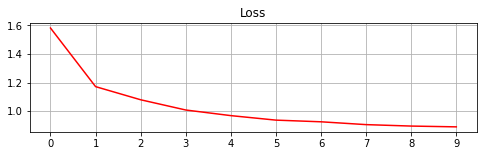

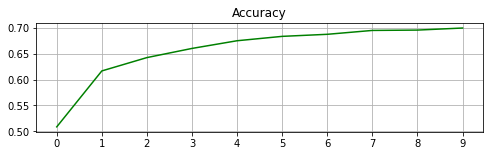

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.09      0.24      0.13       561
[0. 0. 1. 0. 0.]       0.14      0.10      0.12      1166
[0. 0. 0. 1. 0.]       0.13      0.14      0.13      1010
[0. 1. 0. 0. 0.]       0.18      0.14      0.16      1331
[0. 0. 0. 0. 1.]       0.44      0.38      0.41      3043

        accuracy                           0.24      7111
       macro avg       0.20      0.20      0.19      7111
    weighted avg       0.27      0.24      0.25      7111



In [ ]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(1024, activation = "relu", kernel_regularizer=regularizers.l2(1e-4))(output)
layers.Dropout(0.1)
output = layers.Dense(512, activation = "relu", kernel_regularizer=regularizers.l2(1e-4))(output)
layers.Dropout(0.1)
output = layers.Dense(256, activation = "relu", kernel_regularizer=regularizers.l2(1e-4))(output)
layers.Dropout(0.1)
output = layers.Dense(5,  activation = "softmax", kernel_regularizer=regularizers.l2(1e-4))(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

# FINAL MODEL

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_111 (Dense)            (None, 1024)              10241024  
_________________________________________________________________
dense_112 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_113 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_114 (Dense)            (None, 5)                 1285      
Total params: 10,898,437
Trainable params: 10,898,437
Non-trainable params: 0
______________________________________________

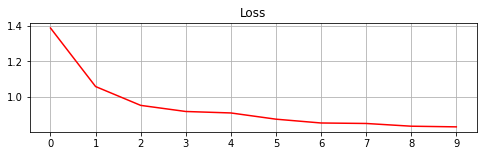

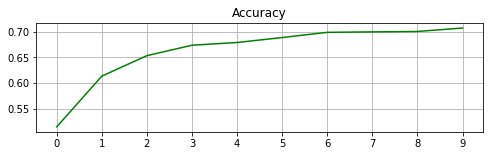

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '





Classification Report of this model is :

                  precision    recall  f1-score   support

[1. 0. 0. 0. 0.]       0.08      0.19      0.11       561
[0. 0. 1. 0. 0.]       0.17      0.13      0.15      1166
[0. 0. 0. 1. 0.]       0.15      0.13      0.14      1010
[0. 1. 0. 0. 0.]       0.20      0.18      0.19      1331
[0. 0. 0. 0. 1.]       0.42      0.38      0.40      3043

        accuracy                           0.25      7111
       macro avg       0.20      0.20      0.20      7111
    weighted avg       0.27      0.25      0.26      7111



In [ ]:
input = layers.Input(shape = (100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(1024, activation = "relu")(output)
output = layers.Dense(512,  activation = "relu")(output)
output = layers.Dense(256,  activation = "relu")(output)
output = layers.Dense(5,  activation = "softmax")(output)
model = models.Model(inputs = input, outputs = output)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss = LOSS, metrics=[METRICS])
model.summary()

history = model.fit(TrainData, validation_data=TestData, epochs = EPOCH)

DrawPlots(history)
ClassificationReport(model, TestData,TARGET_NAMES)

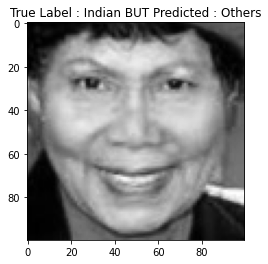

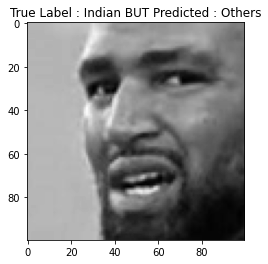

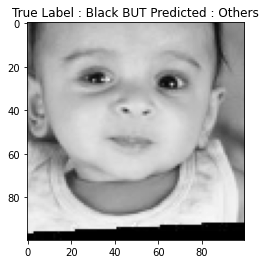

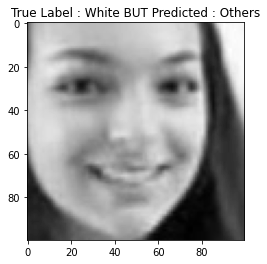

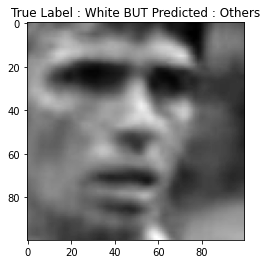

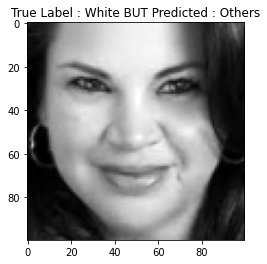

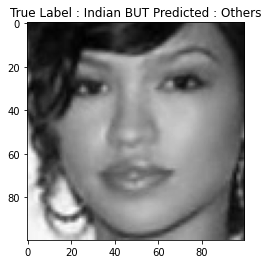

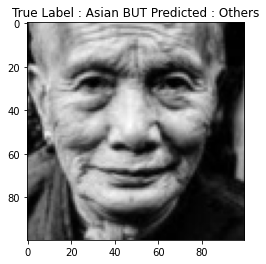

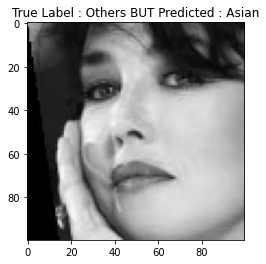

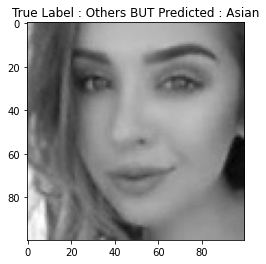

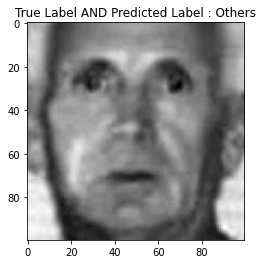

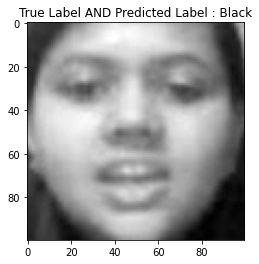

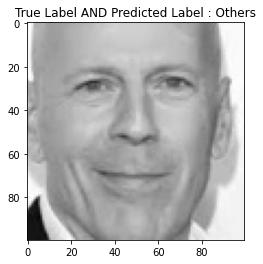

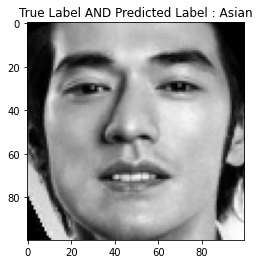

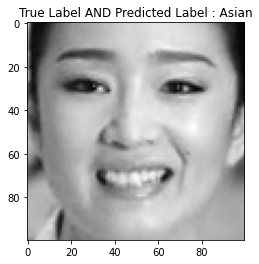

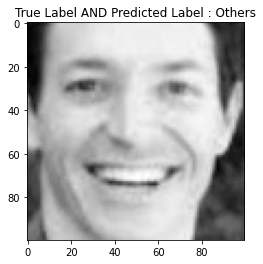

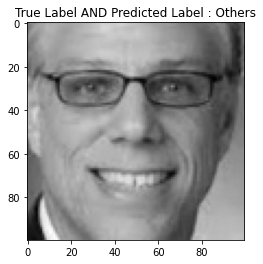

In [ ]:
images, TrueLabels = TestData.next()
ShowSample = 10

WrongeDetected = 0
flagWrongFinish = False

RightDetected = 0
flagRightFinish = False

for image, TrueLabel in zip(images, TrueLabels):
  predLabel = model.predict(np.expand_dims(image,axis=0))
  predClass = backend.argmax(predLabel).numpy()
  predGen = classLabels[int(predClass)]

  trueClass = backend.argmax(TrueLabel).numpy()
  trueGen = classLabels[int(trueClass)]

  if WrongeDetected >= ShowSample:
    flagWrongFinish = True

  if predGen != trueGen and not flagWrongFinish:
    WrongeDetected += 1
    plotTitle = ""
    plotTitle += "True Label : " + str(trueGen) + " BUT Predicted : " +  str(predGen)
    plt.title(plotTitle)
    plt.imshow(image.reshape(100, 100), cmap="gray")
    plt.show()

  if RightDetected >= ShowSample:
    flagRightFinish = True

  if predGen == trueGen and flagWrongFinish and not flagRightFinish:
    RightDetected += 1
    plotTitle = ""
    plotTitle += "True Label AND Predicted Label : " + str(trueGen)
    plt.title(plotTitle)
    plt.imshow(image.reshape(100, 100), cmap="gray")
    plt.show()

# PHASE 4